In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

from bs4 import BeautifulSoup
import regex as re
import nltk

from gensim.models.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# EDA

In [3]:
tweets = pd.read_csv('./datasets/tweets_with_lang.csv')
tweets.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
users = pd.read_csv('./datasets/NBC/users.csv')

In [5]:
tweets.shape

(203133, 18)

In [6]:
tweets.dtypes

user_id                  float64
user_key                  object
created_at                object
created_str               object
retweet_count             object
retweeted                 object
favorite_count           float64
text                      object
tweet_id                  object
source                    object
hashtags                  object
expanded_urls             object
posted                    object
mentions                  object
retweeted_status_id      float64
in_reply_to_status_id    float64
cleaned_text              object
lang                      object
dtype: object

In [7]:
tweets.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id,cleaned_text,lang
0,2.532612e+09,kathiemrr,1488207240000.0,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,8.362278918976512e+17,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN,kissing auntie in the lips,en
1,2.531160e+09,traceyhappymom,1471272620000.0,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,7.651989482398106e+17,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN,rt the more pessimistic we are,en
2,NaN,evewebster373,1435701369000.0,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,6.160023065727468e+17,NaN,[],[],POSTED,[],NaN,NaN,rt ready to feel like a failure joan of arc wa...,en
3,4.840552e+09,blacktolive,1474013088000.0,2016-09-16 08:04:48,18.0,False,17.0,Amen! #blacklivesmatter https://t.co/wGffaOqgzl,7.766933029261476e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""Blacklivesmatter""]",[],POSTED,[],NaN,NaN,amen,unknown
4,1.694026e+09,jacquelinisbest,1474227985000.0,2016-09-18 19:46:25,0.0,False,0.0,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,7.775946478750597e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""WakeUpAmerica""]","[""http://ln.is/twitchy.com/loriz-31/3yafU""]",POSTED,"[""nahbabynah""]",7.775915e+17,NaN,rt twitchy chuck todd caught out there shillin...,en


In [8]:
# dropping duclicated tweets
tweets.duplicated(['tweet_id', 'user_key', 'created_at']).sum()

0

In [9]:
tweets.text.isnull().sum()

7

In [10]:
# dropping duplicates and tweets with no text
tweets.drop_duplicates(['tweet_id', 'user_key', 'created_at'], inplace=True)
tweets.dropna(axis = 0, subset=['cleaned_text'], inplace=True)

In [11]:
tweets.shape

(202105, 18)

**Adding a feature for high volume users**

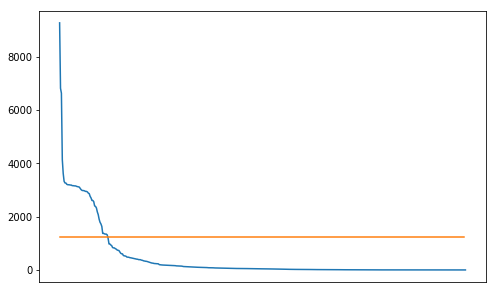

In [12]:
plt.figure(figsize=(8,5))
plt.plot(tweets.user_key.value_counts())
plt.plot((0, 450), (1250, 1250))
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)

In [13]:
high_volume_list = []

for user in set(tweets.user_key):
    if (tweets.user_key == user).sum() >= 1250:
        high_volume_list.append(user)
        
print(len(high_volume_list))        
tweets['high_volume_user'] = tweets.user_key.map(lambda user: True if user in high_volume_list else False)

54


**Adding a Column for Retweets**

In [14]:
tweets['retweet'] = tweets.text.map(lambda x: True if x.split()[0] == 'RT' else False)

In [15]:
# almost 75% of the tweets are retweets
tweets.retweet.sum()

147249

**Cleaning Up Dataframe**

In [16]:
# convert sring date to datetime
tweets['date'] = tweets.created_str.map(lambda date: dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
# set date column as index
tweets.set_index('date', inplace=True)
# reorder index by date
tweets.sort_index(inplace=True)

In [17]:
# keeping necessary columns
tweets = tweets[['user_key', 'text', 'cleaned_text', 'hashtags', 'lang', 'high_volume_user', 'retweet']]

In [18]:
tweets.head()

,user_key,text,cleaned_text,hashtags,lang,high_volume_user,retweet
date,,,,,,,
2014-07-14 18:04:55,evagreen69,I am in Love with LOVE!,i am in love with love,[],en,True,False
2014-07-17 20:27:52,austinlovesbeer,Why give second chances when there are people ...,why give second chances when there are people ...,[],en,False,False
2014-07-20 06:30:01,heyits_toby,"True tolerance does not consist in saying, ""Yo...",true tolerance does not consist in saying you ...,[],en,True,False
2014-07-20 07:02:33,heyits_toby,oh and Ur in a position to judge me because? t...,oh and ur in a position to judge me because tw...,[],en,True,False
2014-07-22 08:46:37,austinlovesbeer,I'm here and you're there. There doesn't know ...,i m here and you re there there doesn t know h...,[],en,False,False


In [19]:
# defining masks for further analysis
english_mask = tweets.lang == 'en'
high_volume_mask = tweets.high_volume_user
retweet_mask = tweets.retweet

In [20]:
tweets.to_csv('./datasets/cleaned_tweets.csv')

# Time Series

Since we are looking at posting frequency, I will look at all posts from high volume users, regardless of whether their language or whether they are in English. In order to best utilize python's datetime features the created date column will be converted to string and set as the index.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
high_volume_tweets = tweets.loc[high_volume_mask]

In [23]:
# adding count and cumulative_count columns for frequency analysis
high_volume_tweets['count'] = 1
high_volume_tweets['cumulative_count'] = range(len(high_volume_tweets))

In [24]:
# specifying specific time series dates
rnc = dt.datetime.strptime('2016-07-18', '%Y-%m-%d')
elec = dt.datetime.strptime('2016-11-07', '%Y-%m-%d')
sc = dt.datetime.strptime('2017-05-17', '%Y-%m-%d')

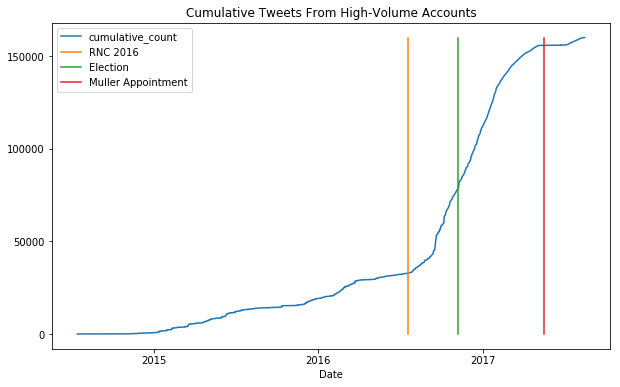

In [25]:
# plotting cumulative tweets over time
plt.figure(figsize=(10, 6))
plt.plot(high_volume_tweets.cumulative_count)
plt.plot((rnc, rnc), (0, 160000), label='RNC 2016')
plt.plot((elec, elec), (0, 160000), label='Election')
plt.plot((sc, sc), (0, 160000), label='Muller Appointment')
plt.title('Cumulative Tweets From High-Volume Accounts')
plt.xlabel('Date')
plt.xticks([dt.datetime(2015, 1, 1), dt.datetime(2016, 1, 1), dt.datetime(2017, 1, 1)])
plt.yticks([0, 50000, 100000, 150000])
plt.legend();

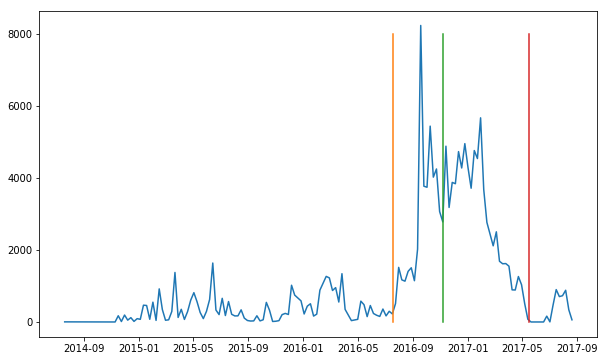

In [26]:
# plotting tweeting frequency averged by month
plt.figure(figsize=(10, 6))
plt.plot(high_volume_tweets.resample('W')['count'].sum())
plt.plot((rnc, rnc), (0, 8000))
plt.plot((elec, elec), (0, 8000))
plt.plot((sc, sc), (0, 8000));

In [27]:
ten_gop_frequency = high_volume_tweets.loc[high_volume_tweets.user_key == 'ten_gop'].resample('D')['count'].sum()

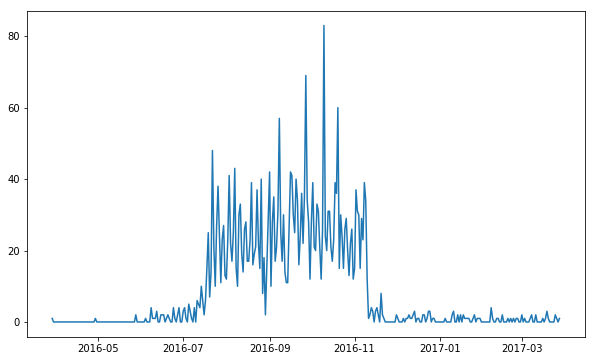

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(ten_gop_frequency);

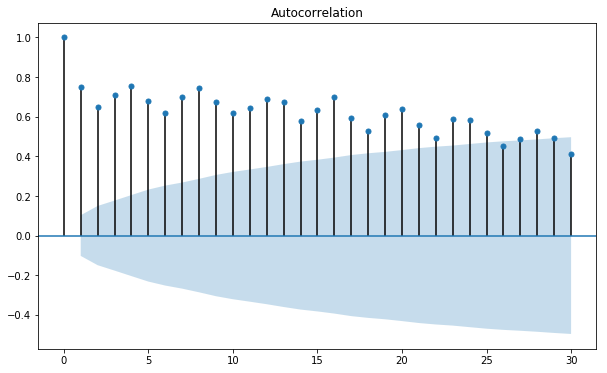

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
plot_acf(ten_gop_frequency, lags=30, ax=ax);

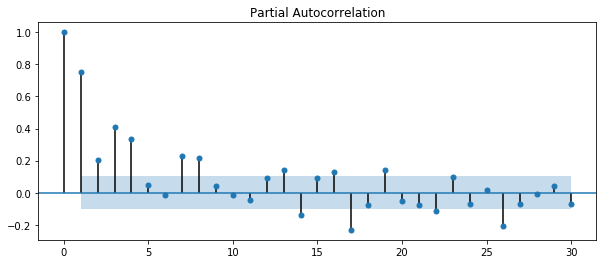

In [30]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(ten_gop_frequency, lags=30, ax=ax);

In [31]:
leroy_frequency = high_volume_tweets.loc[high_volume_tweets.user_key == 'leroylovesusa'].resample('D')['count'].sum()

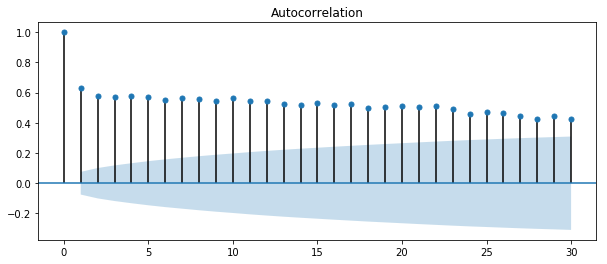

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(leroy_frequency, lags=30, ax=ax);

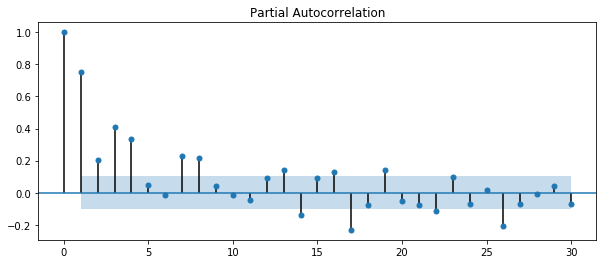

In [33]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(ten_gop_frequency, lags=30, ax=ax);

In [34]:
high_volume_list

['cassieweltch',
 'notritahart',
 'giselleevns',
 'patriotraphael',
 'rh0lbr00k',
 'garrettsimpson_',
 'daileyjadon',
 'finley1589',
 'willisbonnerr',
 'brianaregland',
 'traceyhappymom',
 'emileewaren',
 'johnbranchh',
 'paulinett',
 'hiimkhloe',
 'puredavie',
 'evagreen69',
 'ten_gop',
 'queenofthewo',
 'pamela_moore13',
 'anthonywoodboy',
 'cookncooks',
 'dorothiebell',
 'patriotblake',
 'datwisenigga',
 'mil0blake',
 'mr_clampin',
 'jeannemccarthy0',
 'jacquelinisbest',
 'kathiemrr',
 'jasper_fly',
 '_nickluna_',
 'leroylovesusa',
 'tpartynews',
 'westernwindwes',
 'lazykstafford',
 'mrclydepratt',
 'judelambertusa',
 'heyits_toby',
 'hyddrox',
 'ryanmaxwell_1',
 'jeffreykahunas',
 'melanymelanin',
 'laurabaeley',
 'kateritterrrr',
 'hollandpatrickk',
 'malloryjared',
 'baobaeham',
 'thefoundingson',
 'evewebster373',
 'priceforpierce',
 'melvinsroberts',
 'ameliebaldwin',
 'michellearry']

In [35]:
english_tweets = tweets.loc[english_mask]
english_tweets = english_tweets.iloc[22356:]
english_tweets.shape

(161597, 7)

In [36]:
english_high_volume_list = []

for user in set(english_tweets.user_key):
    if (english_tweets.user_key == user).sum() >= 1000:
        english_high_volume_list.append(user)
        
print(len(english_high_volume_list)) 
english_tweets['high_volume_user'] = english_tweets.user_key.map(lambda user: True if user in english_high_volume_list else False)

49


In [37]:
# manual categorization of political audiences
political_targets = {'cookncooks' :  'Right',
                     'michellearry' : 'Right',
                     'jacquelinisbest' : 'Right',
                     'mil0blake' : 'Right',
                     'hyddrox' : 'Right',
                     '_nickluna_' : 'Right',
                     'notritahart' : 'Left',
                     'judelambertusa' : "Right",
                     'mrclydepratt' : 'Left',
                     'heyits_toby' : 'Right',
                     'ten_gop' : 'Left',
                     'emileewaren' : 'Right',
                     'hiimkhloe' : 'Left',
                     'anthonywoodboy' : 'Right',
                     'pamela_moore13' : 'Right',
                     'brianaregland' : 'Left',
                     'micparrish' : 'Right',
                     'datwisenigga' : 'Left',
                     'evagreen69' : 'Right',
                     'giselleevns' : 'Left',
                     'jeannemccarthy0' : 'Right',
                     'queenofthewo' : 'Left',
                     'garrettsimpson_' : 'Right',
                     'finley1589' : 'Right',
                     'willisbonnerr' : 'Left',
                     'melanymelanin' : 'Left',
                     'paulinett' : 'Left',
                     'malloryjared' : 'Left',
                     'daileyjadon' : 'Left',
                     'thefoundingson' : 'Right',
                     'patriotblake' : 'Right',
                     'leroylovesusa' : 'Right',
                     'rh0lbr00k' : 'Right',
                     'traceyhappymom' : 'Left',
                     'tpartynews' : 'Right',
                     'dorothiebell' : 'Right',
                     'kateritterrrr' : 'Right',
                     'puredavie' : 'Right',
                     'priceforpierce' : 'Right',
                     'ameliebaldwin' : 'Right',
                     'jeffreykahunas' : 'Right',
                     'patriotraphael' : 'Right',
                     'ryanmaxwell_1' : 'Right',
                     'laurabaeley' : 'Right',
                     'lazykstafford' : 'Right'
                    }

In [39]:
english_tweets = english_tweets.loc[english_tweets.high_volume_user]
english_tweets['target_audience'] = english_tweets.user_key.map(political_targets).value_counts()

In [41]:
#english_tweets.to_csv('./datasets/lda_ready_tweets.csv')